**Curso de Inteligencia Artificial y Aprendizaje Profundo**


# Redes Recurrentes. Ejemplo 1: Serie de tiempo simulada

##  Autores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Oleg Jarma, ojarmam@unal.edu.co
4. Maria del Pilar Montenegro, pmontenegro88@gmail.com

## Contenido

* [Introducción](#Introducción)
* [El problema de las dependencias a largo plazo](El-problema-de-las-dependencias-a-largo-plazo)
* [Redes LSTM](#Redes-LSTM)
* [La idea central detras de las redes LSTM](#La-idea-central-detras-de-las-redes-LSTM)
* [Caminando a lo largo de una red LSTM. Paso a paso](#Caminando-a-lo-largo-de-una-red-LSTM.-Paso-a-paso)
* [Estructura Matemática de una red LSTM](#Estructura-Matemática-de-una-red-LSTM)
* [Cálculo del número de neuronas de una capa LSTM](#Cálculo-del-número-de-neuronas-de-una-capa-LSTM)


## Referencias

1. [Introducción a Redes LSTM](Intro_LSTM.ipynb)
2. [Time Series Forecasting with LSTMs using TensorFlow 2 and Keras in Python](https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651/)

## Introducción

Los datos de la serie temporal introducen una "dependencia dura" de los pasos de tiempo anteriores, por lo que no se cumple la independencia de las observaciones. ¿Cuáles son algunas de las propiedades que puede tener una serie temporal?

La *estacionalidad* y la *autocorrelación* son algunas de las propiedades de la serie temporal en las que puede estar interesado.

Se dice que una serie de tiempos es **estacionaria** cuando la media y la varianza permanecen constantes en el tiempo. 

Una serie temporal tiene una **tendencia** si la media varía con el tiempo. A menudo puede eliminarlo y hacer que la serie sea estacionaria aplicando transformación(es) logarítmicas de los datos.


**La estacionalidad** se refiere al fenómeno de las variaciones en plazos específicos. por ejemplo, personas que compran más árboles de Navidad durante Navidad (quién lo hubiera pensado). Un enfoque común para eliminar la estacionalidad es usar la diferenciación.

**La autocorrelación** se refiere a la correlación entre el valor actual con una copia de un tiempo anterior (retraso).  

Usaremos redes neuronales para el modelamiento de esta series.

# Modelo LSTM

Este código puede ser usado como base para la impelemntación de modelos mas complejos. Para un introdución teórica a las redes LSTM consulte el cuaderno [Redes LSTM (Long Short Term Memory Networks)](Intro_LSTM.ipynb)


# Predicción de series de tiempo con redes LSTM

Comenzaremos con un ejemplo simple de pronosticar los valores de la función Seno utilizando una red LSTM simple.

## Importar módulos requeridos

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pandas as pd
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
#from tensorflow import keras
#
from tensorflow.keras.layers import Input, LSTM, Dense, GRU
from tensorflow.keras.models import Model
#
from tensorflow.keras.optimizers import Adam
#
from tensorflow.keras.utils import plot_model
#
from sklearn.preprocessing import MinMaxScaler
#
print("Versión de Tensorflow: ", tf.__version__)

Versión de Tensorflow:  2.1.0


### Configuraciones básicas generales

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
#
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
#

#tf.random.set_seed(RANDOM_SEED)
#


## Datos sintéticos

Vamos a generar unos datos que siguen un comportamiento sinosoidal, con una tendencia ascendiente. Se introduce ruido Gaussiano. 

Modifique las siguientes dos líneas y haga su priopia simulación.

In [3]:
#
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
trend = .1
#
time = np.arange(0, 100, 0.1)
sin =  trend*time + np.sin(time) + np.random.normal(scale=0.5, size=len(time))

### Primer gráfico. Datos simulados.

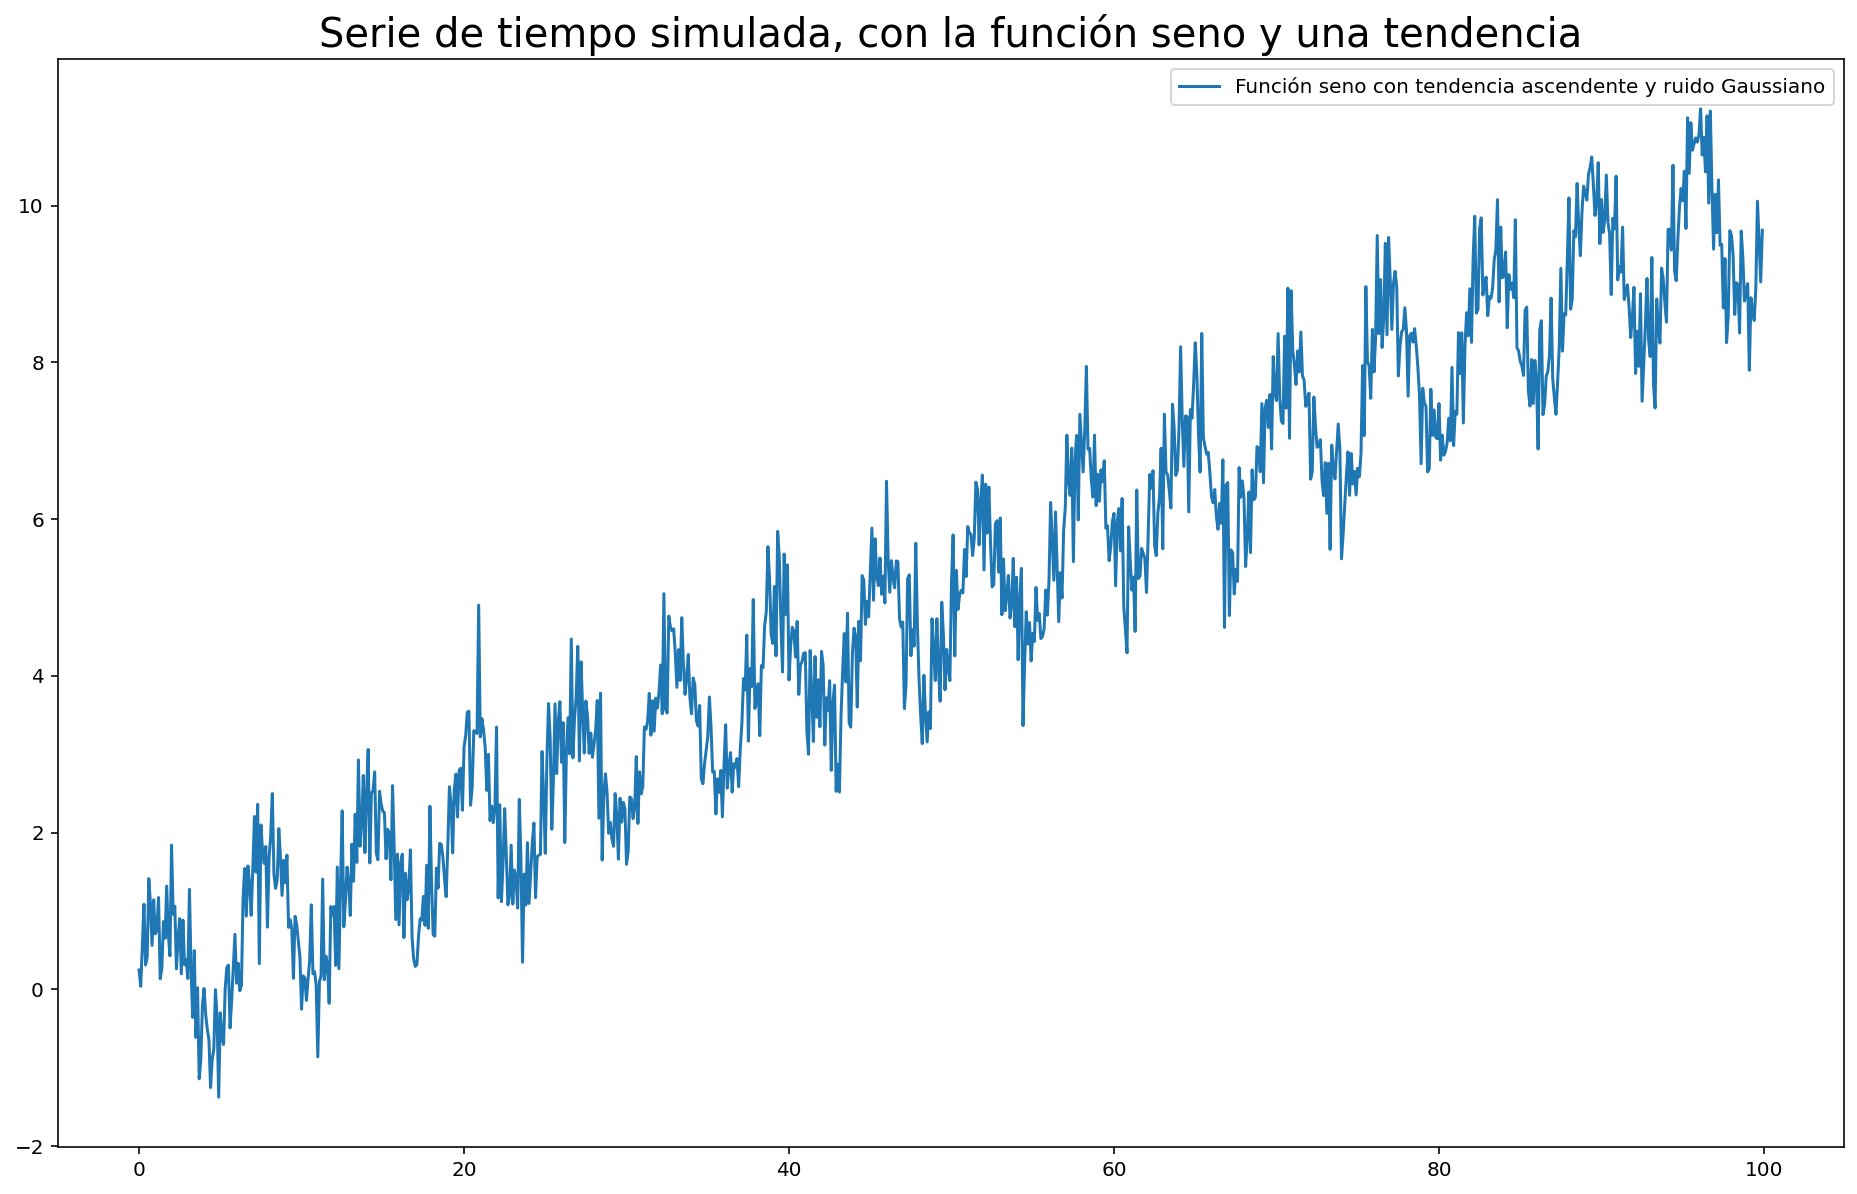

In [4]:
plt.plot(time, sin, label='Función seno con tendencia ascendente y ruido Gaussiano');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()

In [5]:
print( 'Número de datos: ', sin.shape[0])

Número de datos:  1000


## Preprocesamiento de los datos

### Escala los datos

Introducimos un instancia de clase del escalador *MinMaxScaler* para llevar los datos a la escala $[0,1]$

In [6]:
#crea un dataset 
#
df1 = pd.DataFrame(sin, index=time, columns=['serie'])
# crea el objeto  scaler y escala los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1.values)
#
dataset = pd.DataFrame(scaled_data,index=df1.index, columns=['serie'])
#

In [7]:
dataset.shape

(1000, 1)

### Gráfico de datos escalados

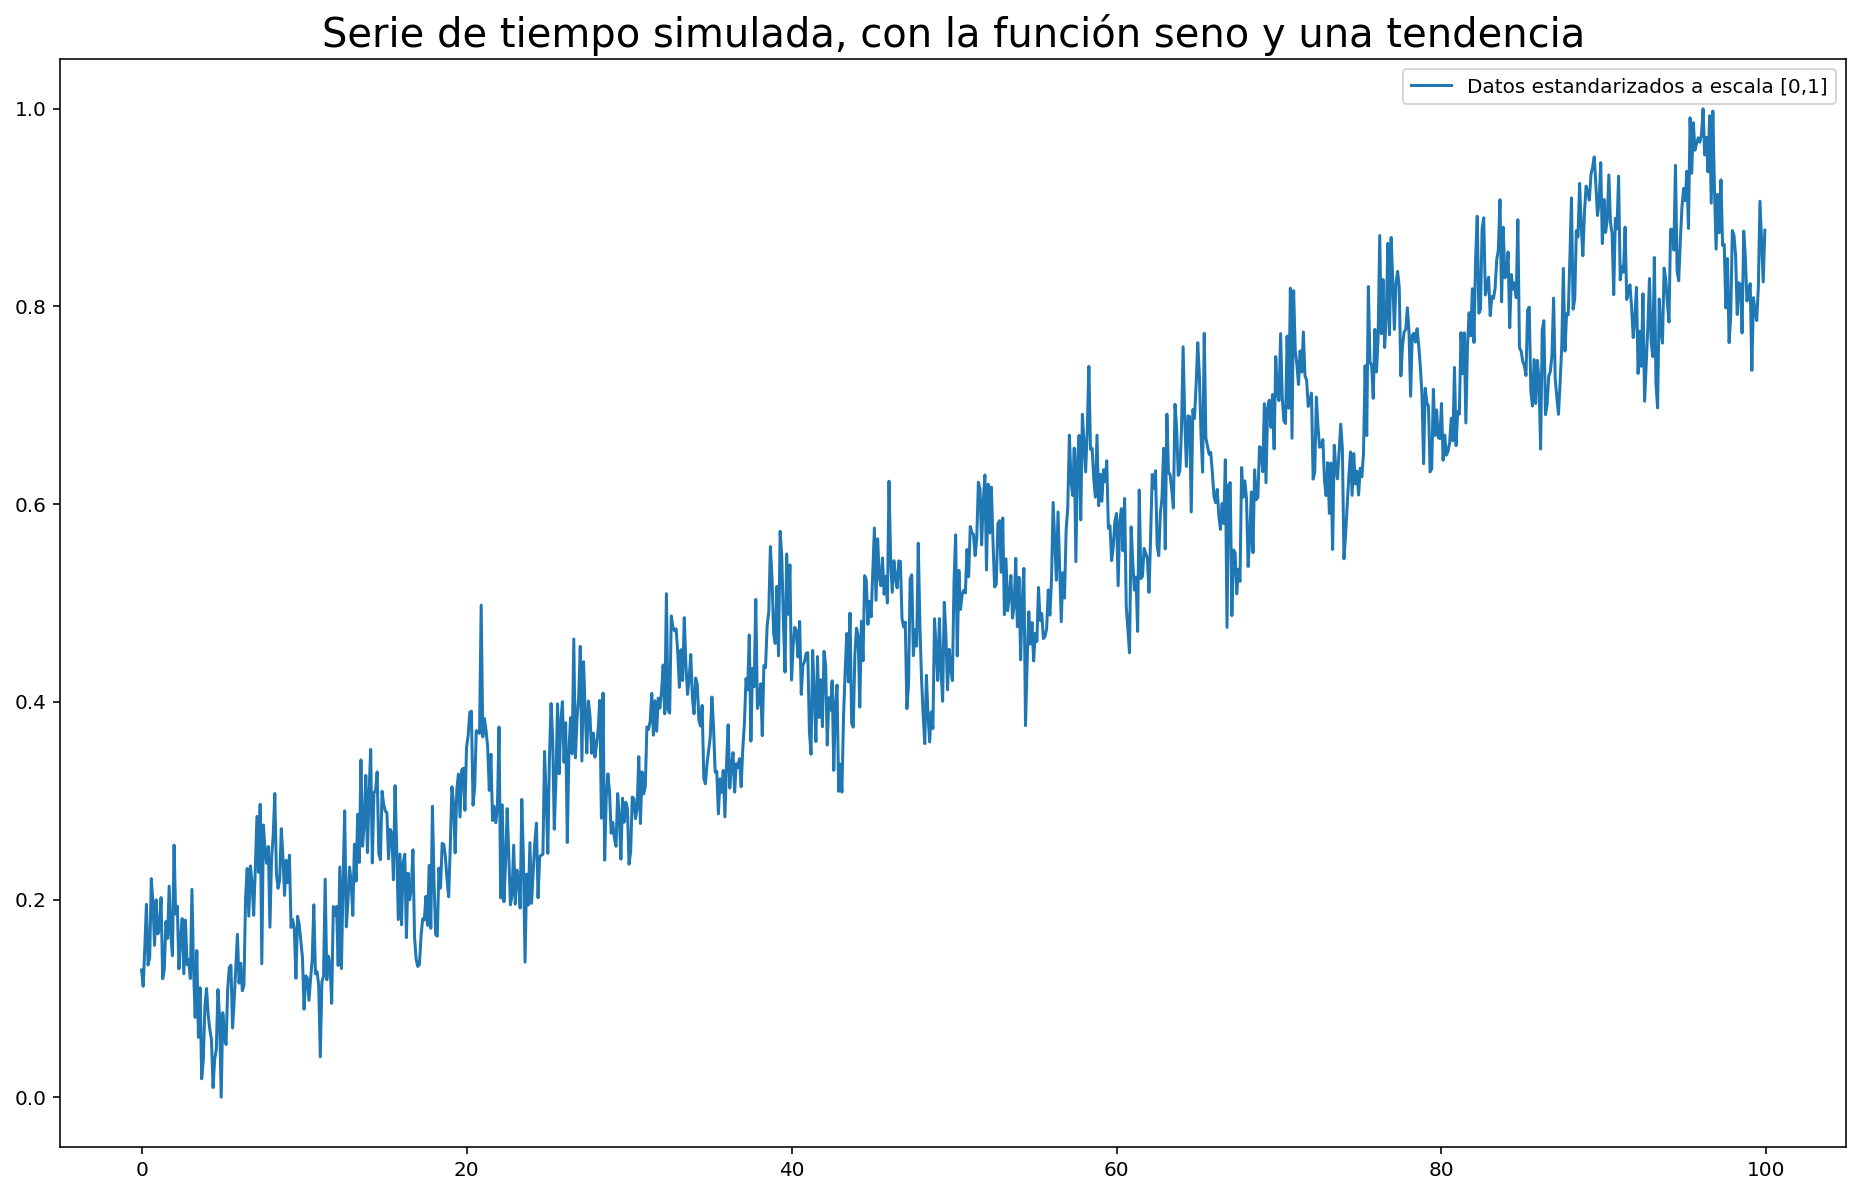

In [8]:
#serie_0_1 = dataset.serie_0_1.values

plt.plot(time, dataset, label='Datos estandarizados a escala [0,1]');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()

###  Separación de datos entrenamiento y de validación

En el caso de las series de tiempo, los datos de entrenamiento se toman desde el comienzo de la serie y los de validación desde el final haci atras. 

Veamos.

In [9]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(df1)]
len_train = len(train)
len_test = len(test)
print(len_train, len_test)

800 200


In [10]:
train.shape

(800, 1)

### Plot que muestra los datos de entrenamiento y los de validación

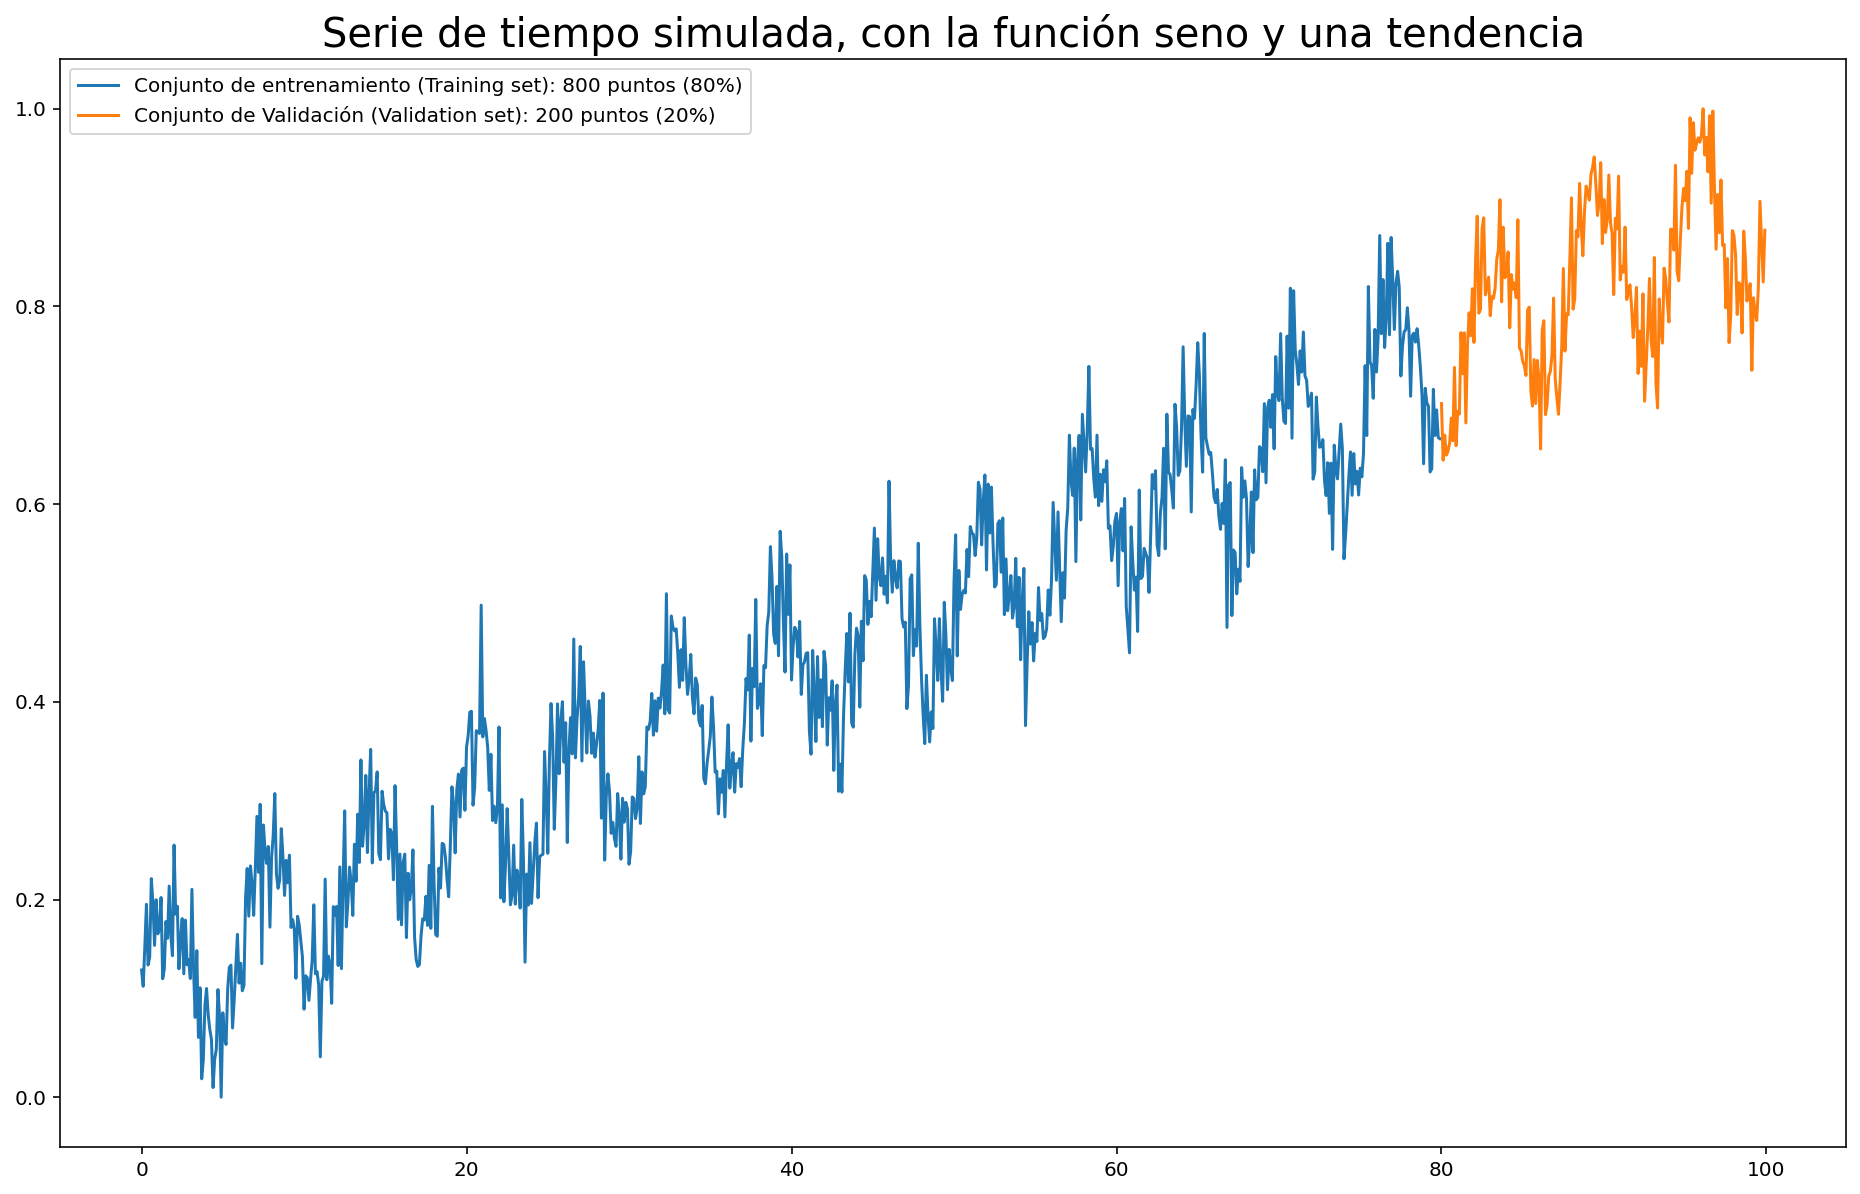

In [11]:
#plt.figure(figsize=(16,8))
plt.plot(train, label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (80%)')
plt.plot(test, label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (20%)') 
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend()
plt.show()

Preparar los datos para la predicción de series temporales (LSTM en particular) puede ser complicado.

Intuitivamente, necesitamos predecir el valor en el paso de tiempo actual utilizando el historial ($n$ pasos de tiempo hacia atrás a partir de él). 


Aquí se propone una función genérica que hace el trabajo

In [13]:
def create_dataset(X, y, time_steps=1):
    # crea dos listas vacias para depositar los datos
    Xs, ys = [], []
    # el primer lote de datos empieza en la primera observación
    # y toma time_steps  datos.
    # Comienza a avanzar hacia adelante.
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

La belleza de esta función es que trabaja con datos de series temporales univariadas (función única) y multivariadas (funciones múltiples). Usemos un historial de 50 pasos de tiempo para hacer nuestras secuencias. ESto significa que vamos a conservar la historia de 50 pasos atrás para predecir el valor actual.

In [14]:
time_steps = 50

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

print(X_train.shape, y_train.shape)

print([X_train[0:2,], y_train[0:2]])

(750, 50, 1) (750, 1)
[array([[[0.12866229],
        [0.1121937 ],
        [0.15199099],
        [0.19517542],
        [0.13373672],
        [0.14166865],
        [0.2211258 ],
        [0.19603986],
        [0.15358548],
        [0.19974127],
        [0.16525499],
        [0.16990083],
        [0.20199465],
        [0.11982438],
        [0.12982285],
        [0.17767362],
        [0.16076588],
        [0.21355511],
        [0.16446774],
        [0.14307962],
        [0.25505916],
        [0.1851261 ],
        [0.19321062],
        [0.12984983],
        [0.15998183],
        [0.18065415],
        [0.12482759],
        [0.17917075],
        [0.13392128],
        [0.13937234],
        [0.12008995],
        [0.21029807],
        [0.12917938],
        [0.0806848 ],
        [0.14828083],
        [0.0604929 ],
        [0.11070353],
        [0.01858177],
        [0.03791053],
        [0.09315708],
        [0.10995165],
        [0.08338189],
        [0.06856677],
        [0.05846956],
        [

In [15]:
X_train.shape

(750, 50, 1)

## Modelo LSTM


Entrenar un modelo LSTM en Keras es fácil. Utilizaremos la capa LSTM en un modelo secuencial para hacer nuestras predicciones:

### Crea el modelo

In [16]:
# shapes
inputs_shape = (X_train.shape[1], X_train.shape[2])
lstm_output = 60

# layers
inputs = Input(inputs_shape)
x = LSTM(units=lstm_output, name='LSTM_layer')(inputs)
outputs = Dense(1)(x)

# model
serie_0_1_model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')


### Summary del modelo

Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 60)                14880     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


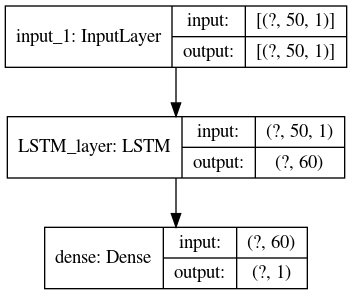

In [17]:
#model = keras.Sequential()
#model.add(keras.layers.LSTM(units=lstm_output,  input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(keras.layers.Dense(units=1))
serie_0_1_model.summary()

plot_model(serie_0_1_model, to_file='../Imagenes/series_LSTM_model.png', 
           show_shapes=True)

Significa que el modelo tiene la primera de tipo LSTM capa con un input de tamaño $(50,1)$ y una salida de 60 neuronas.

La segunda es una capa densa con entrada 60 neuronas y salida una neurona


El cálculo del número de neuronas es como sigue: 

$$
\text{Número de parámetros capa LSTM } = 4(p^2+ pn +p)
$$

en donde $p$ es el tamaño de salida y $n$ el tamaño de entrada.

In [21]:
lstm_output =60
input_size =1 # input size in the LSTM machine
#
# cada entrada de tamaño 50 es mostrada a la máquina  LSTM machine uno por uno.
# luego se tiene
#
num_params = 4*(lstm_output*lstm_output + lstm_output*input_size+ lstm_output)
num_params

14880

### Compila

In [22]:
serie_0_1_model.compile(loss='mean_squared_error',
  optimizer=Adam(0.001)
)

## Entrenamiento

Lo más importante para recordar al entrenar modelos de series temporales es no mezclar los datos (el orden de los datos es importante). El resto es bastante estándar:

In [23]:
history = serie_0_1_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 675 samples, validate on 75 samples
Epoch 1/30
675/675 [==============================] - 7s 11ms/sample - loss: 0.0082 - val_loss: 0.0033
Epoch 2/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0057 - val_loss: 0.0031
Epoch 3/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0045 - val_loss: 0.0025
Epoch 4/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0034 - val_loss: 0.0024
Epoch 5/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0027 - val_loss: 0.0023
Epoch 6/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0025 - val_loss: 0.0021
Epoch 7/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0024 - val_loss: 0.0020
Epoch 8/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0023 - val_loss: 0.0019
Epoch 9/30
675/675 [==============================] - 3s 4ms/sample - loss: 0.0023 - val_loss: 0.0019
Epoch 10/30
675/675 [===============

## Evaluación del Modelo

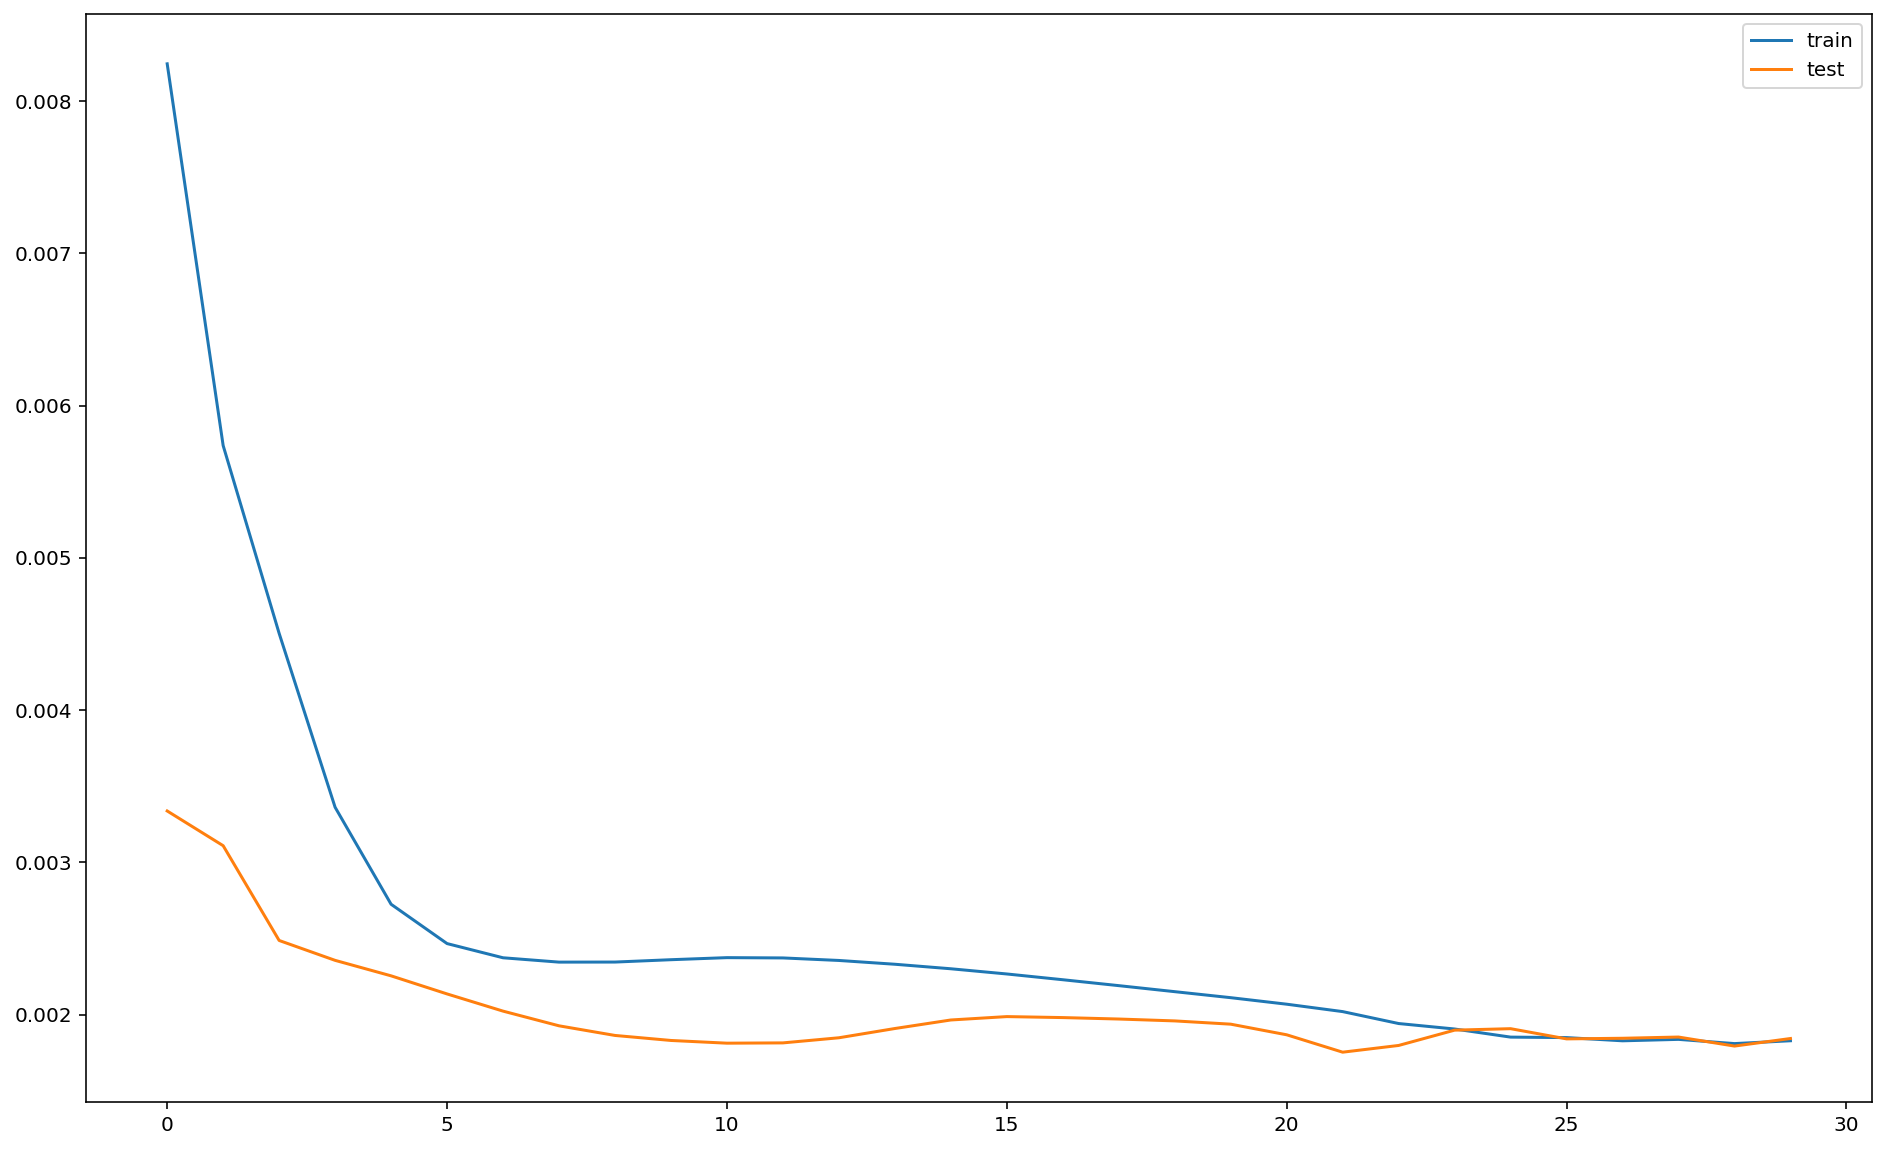

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [25]:
y_pred =serie_0_1_model.predict(X_test)

In [ ]:
#y_pred

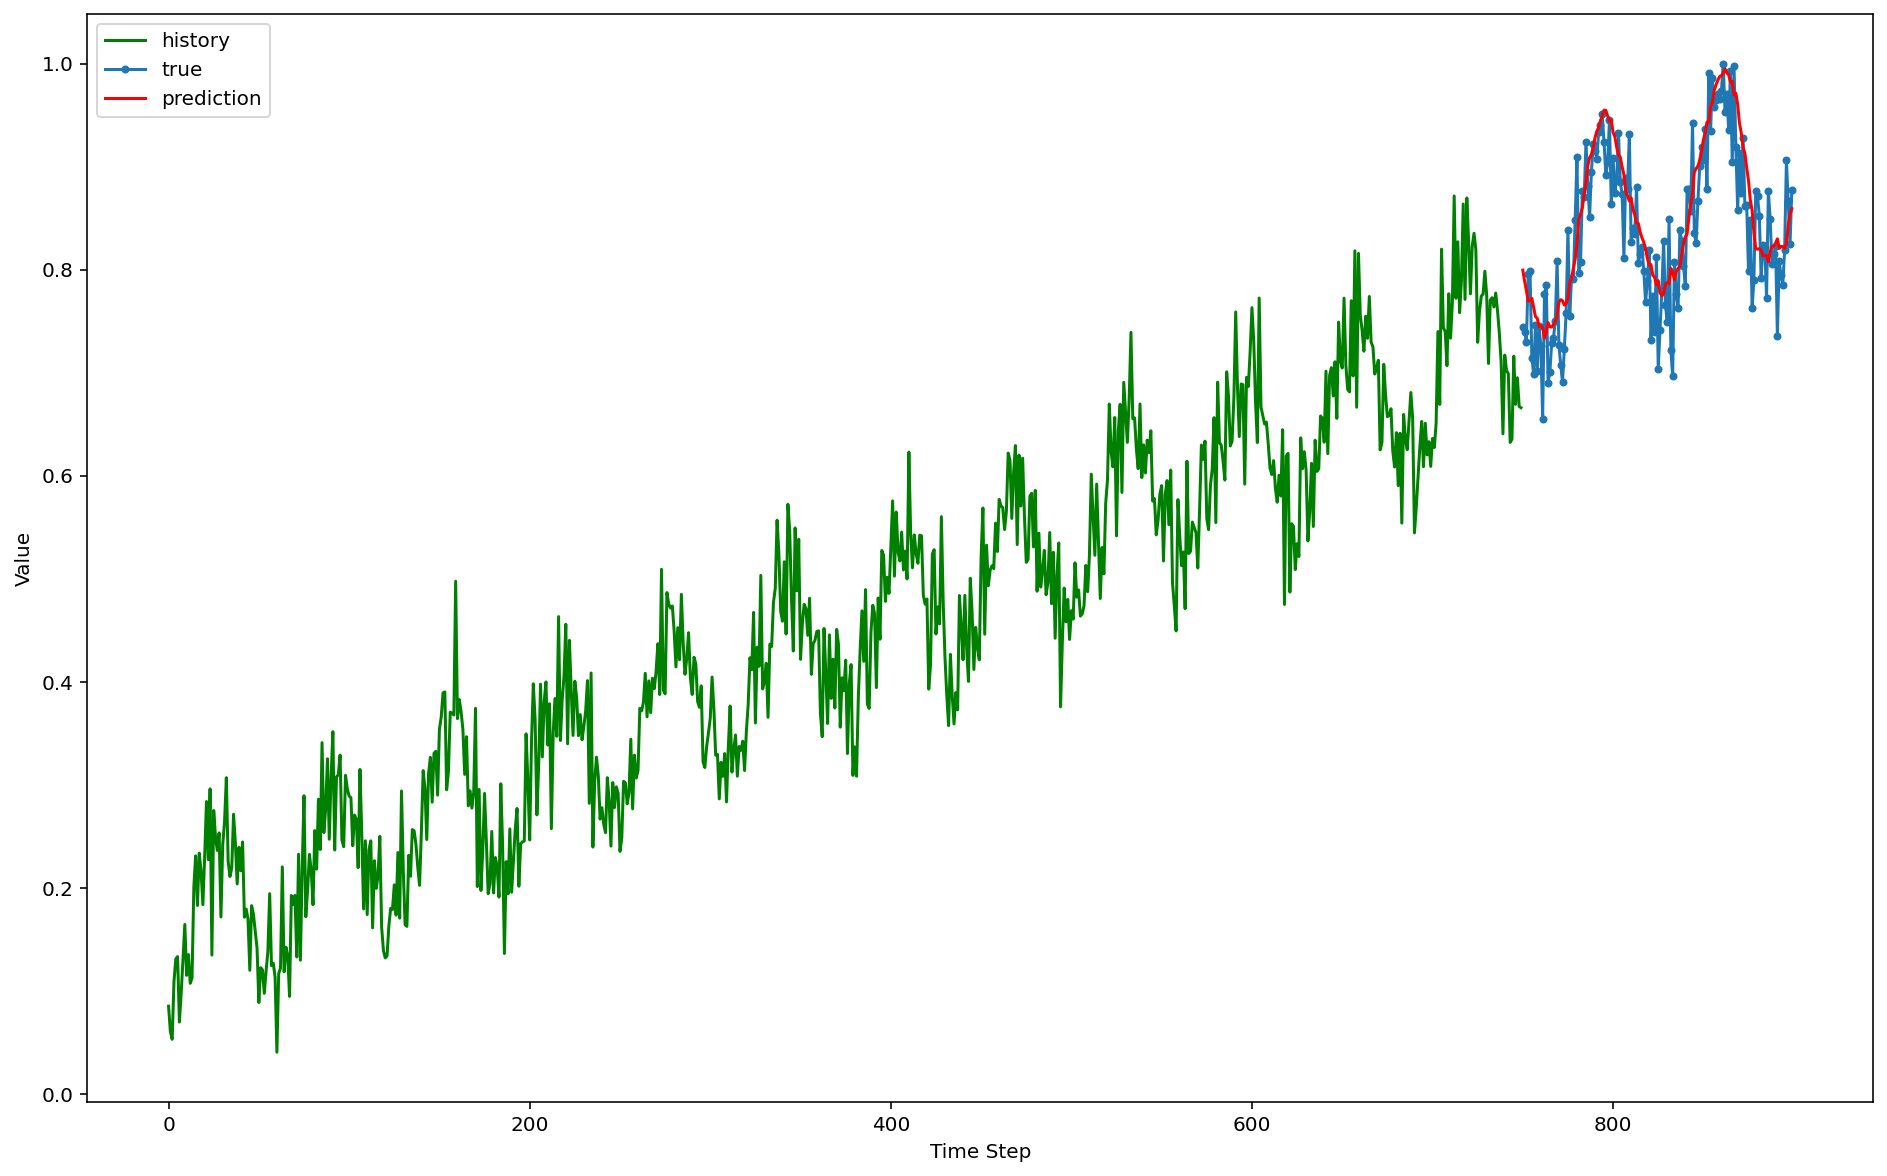

In [27]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

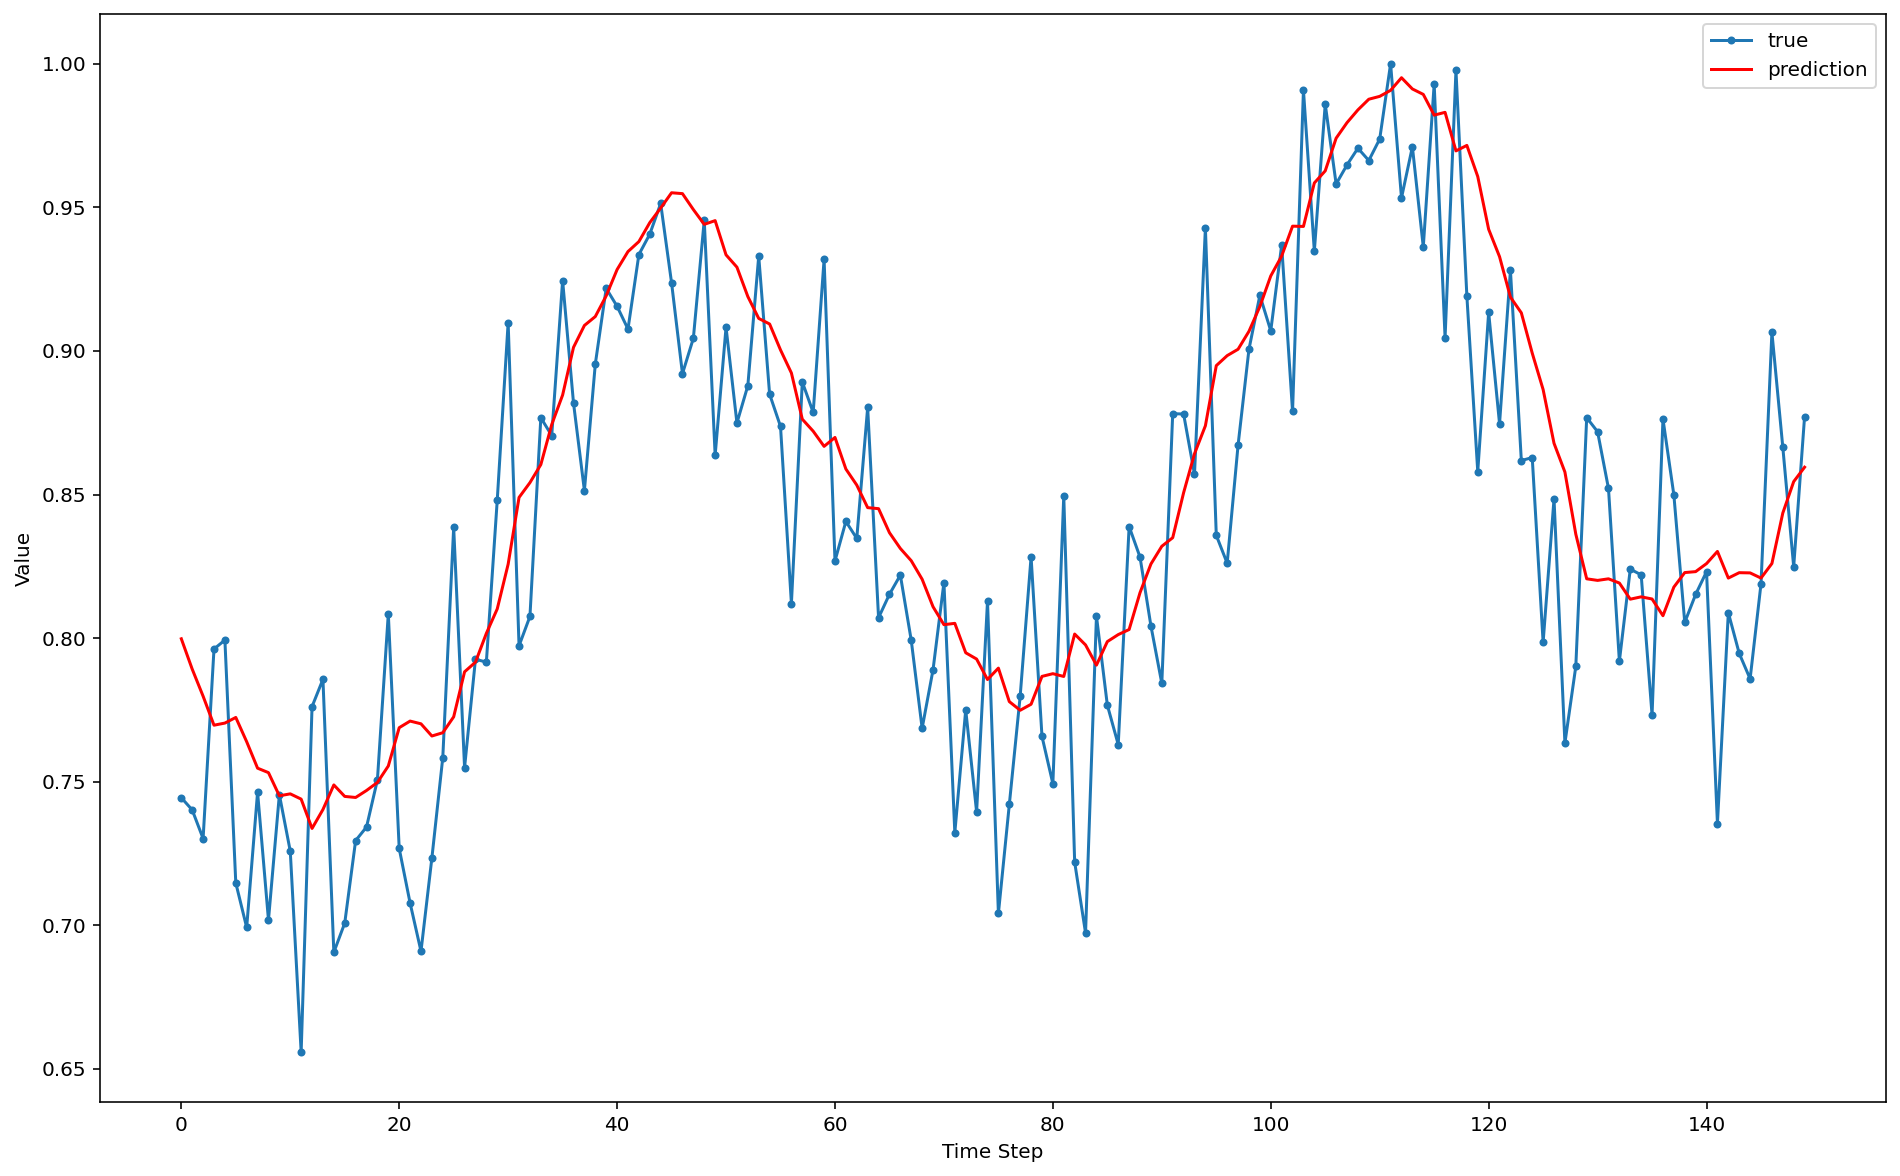

In [28]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();



## Transforma a la escala original

In [29]:
scaled_data = scaler.fit_transform(df1.values)
dataset = pd.DataFrame(scaled_data)
dataset.columns = ['sine']
dataset.index = df1.index

In [30]:
y_pred = scaler.inverse_transform(y_pred)


In [31]:
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [32]:
y_test.shape

(150, 1)

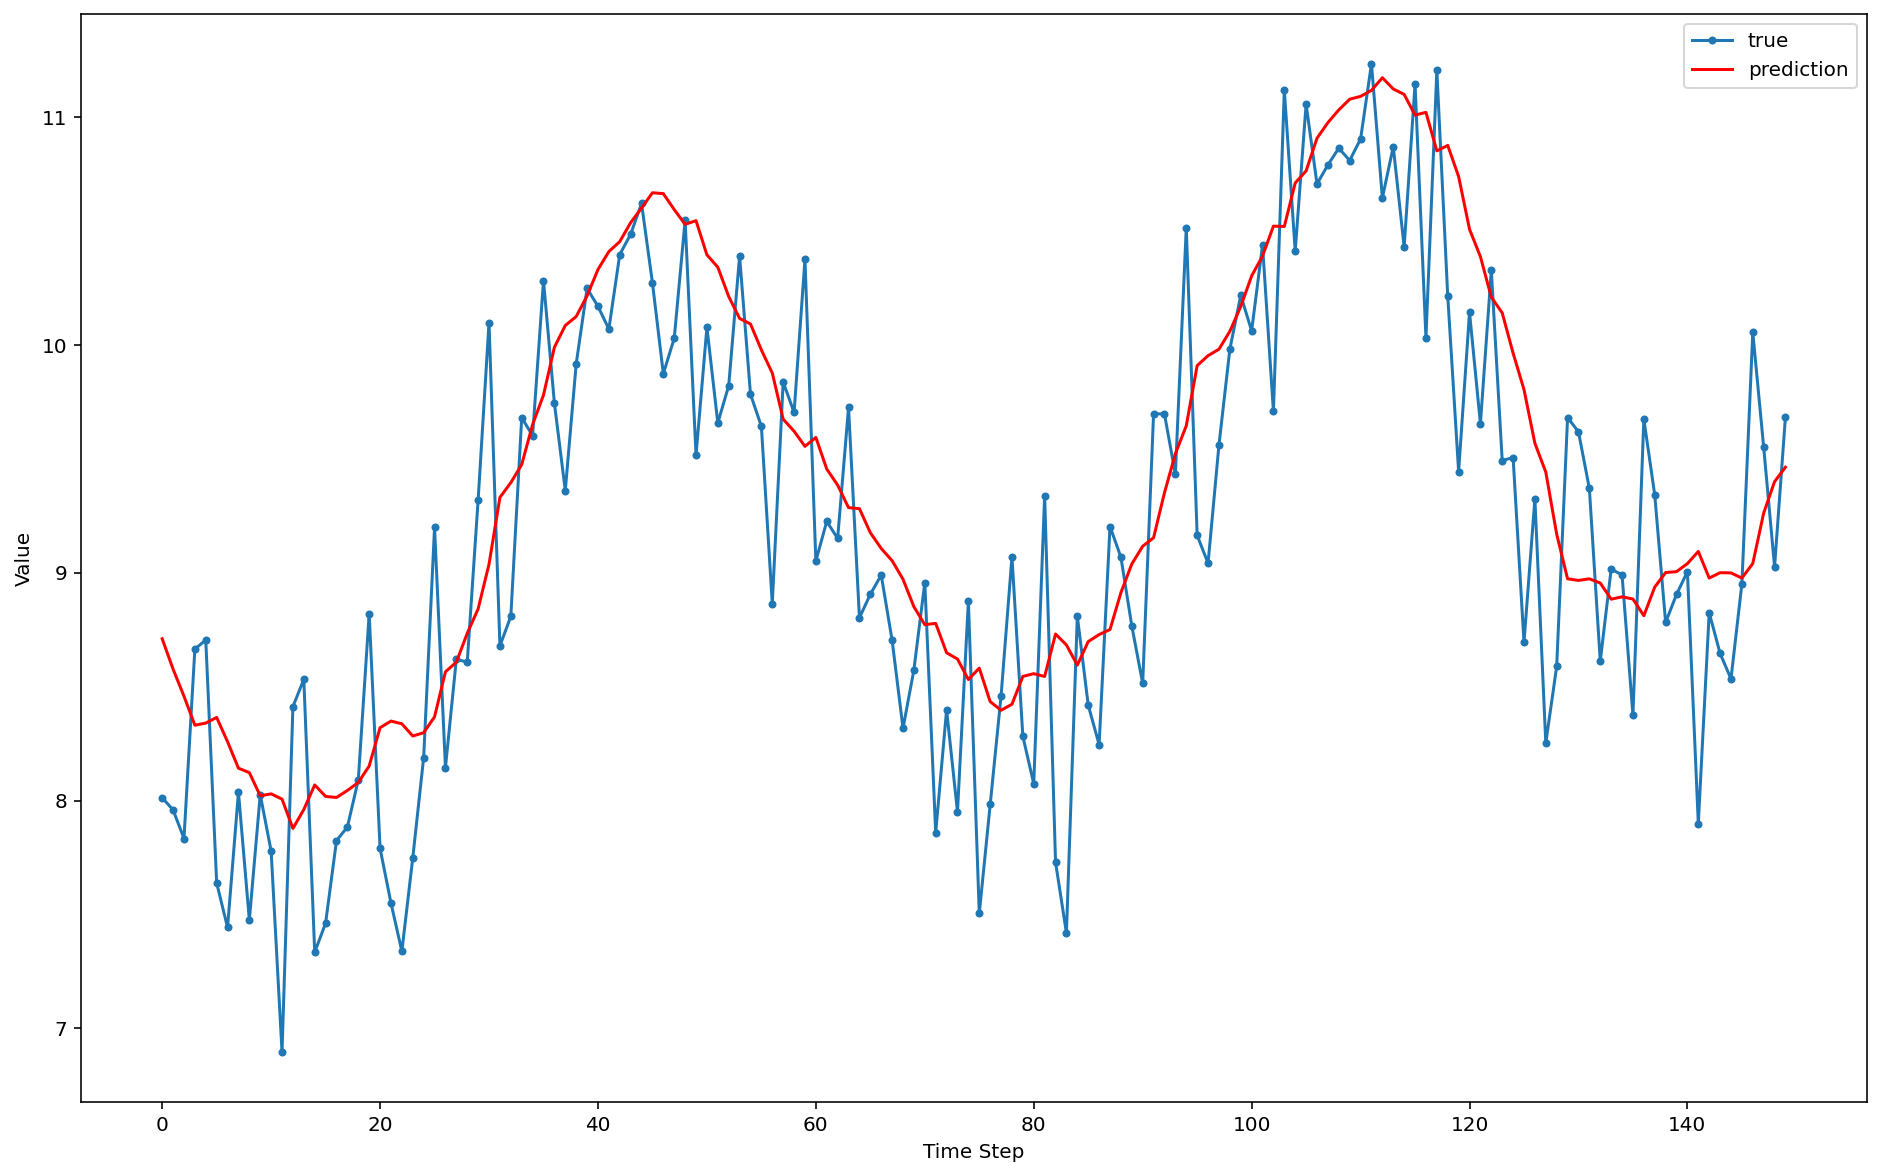

In [33]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Modelo GRU

Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
GRU_layer (GRU)              (None, 60)                11340     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 11,401
Trainable params: 11,401
Non-trainable params: 0
_________________________________________________________________


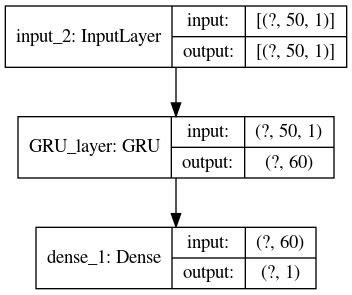

In [34]:
# shapes
inputs_shape = (X_train.shape[1], X_train.shape[2])
lstm_output = 60

# layers
inputs = Input(inputs_shape)
x = GRU(units=lstm_output, name='GRU_layer')(inputs)
outputs = Dense(1)(x)

# model
serie_0_1_model_gru = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')


# summary
serie_0_1_model_gru.summary()

plot_model(serie_0_1_model_gru, to_file='../Imagenes/series_LSTM_model.png', 
           show_shapes=True)

In [35]:
# compila
serie_0_1_model_gru.compile(loss='mean_squared_error',
  optimizer=Adam(0.001)
)

In [36]:
# entrena
history = serie_0_1_model_gru.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 675 samples, validate on 75 samples
Epoch 1/30
675/675 [==============================] - 7s 11ms/sample - loss: 0.0047 - val_loss: 0.0022
Epoch 2/30
675/675 [==============================] - 3s 4ms/sample - loss: 0.0056 - val_loss: 0.0022
Epoch 3/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0037 - val_loss: 0.0020
Epoch 4/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0025 - val_loss: 0.0020
Epoch 5/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0022 - val_loss: 0.0020
Epoch 6/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 7/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 8/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0021 - val_loss: 0.0019
Epoch 9/30
675/675 [==============================] - 2s 4ms/sample - loss: 0.0022 - val_loss: 0.0019
Epoch 10/30
675/675 [===============

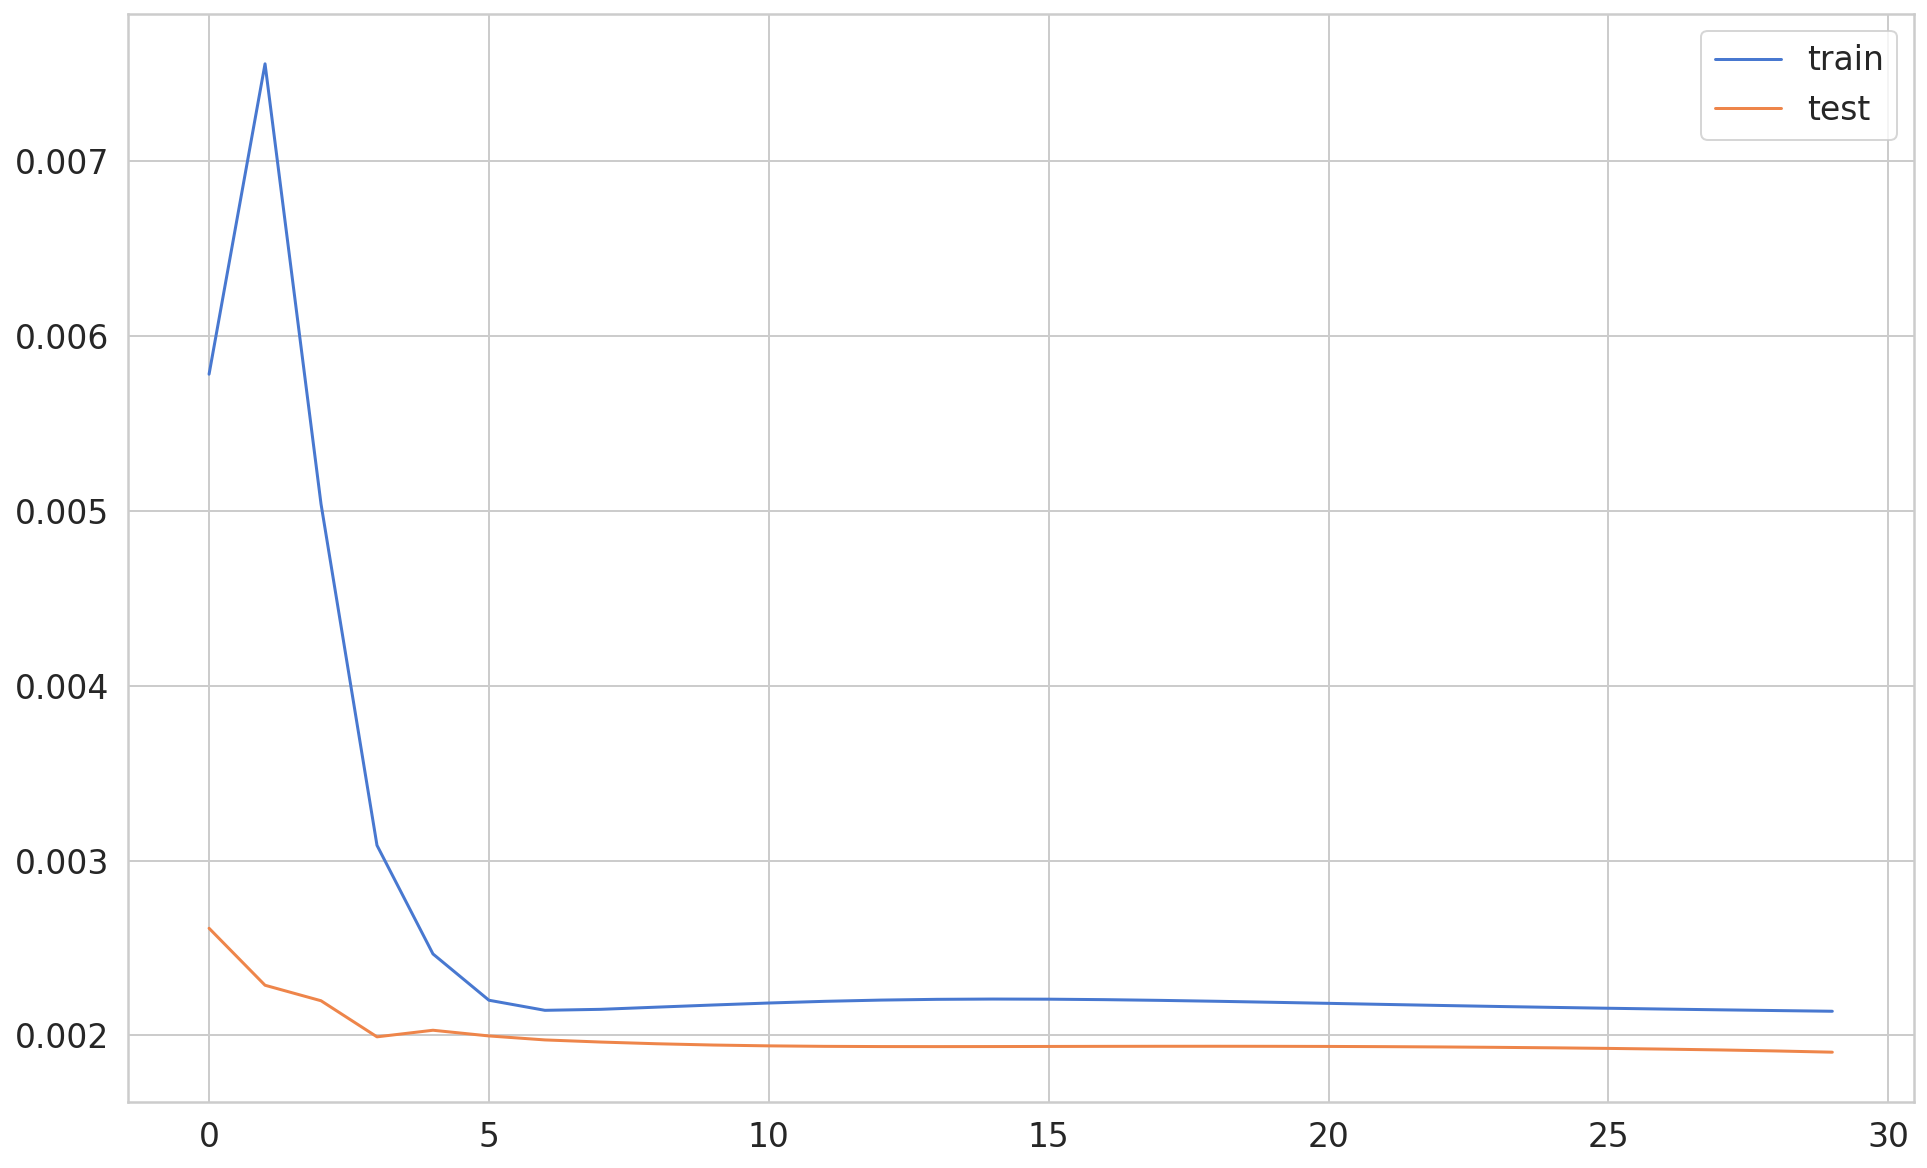

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [35]:
y_pred_gru =serie_0_1_model_gru.predict(X_test)
# escala original
y_pred_gru = scaler.inverse_transform(y_pred_gru)

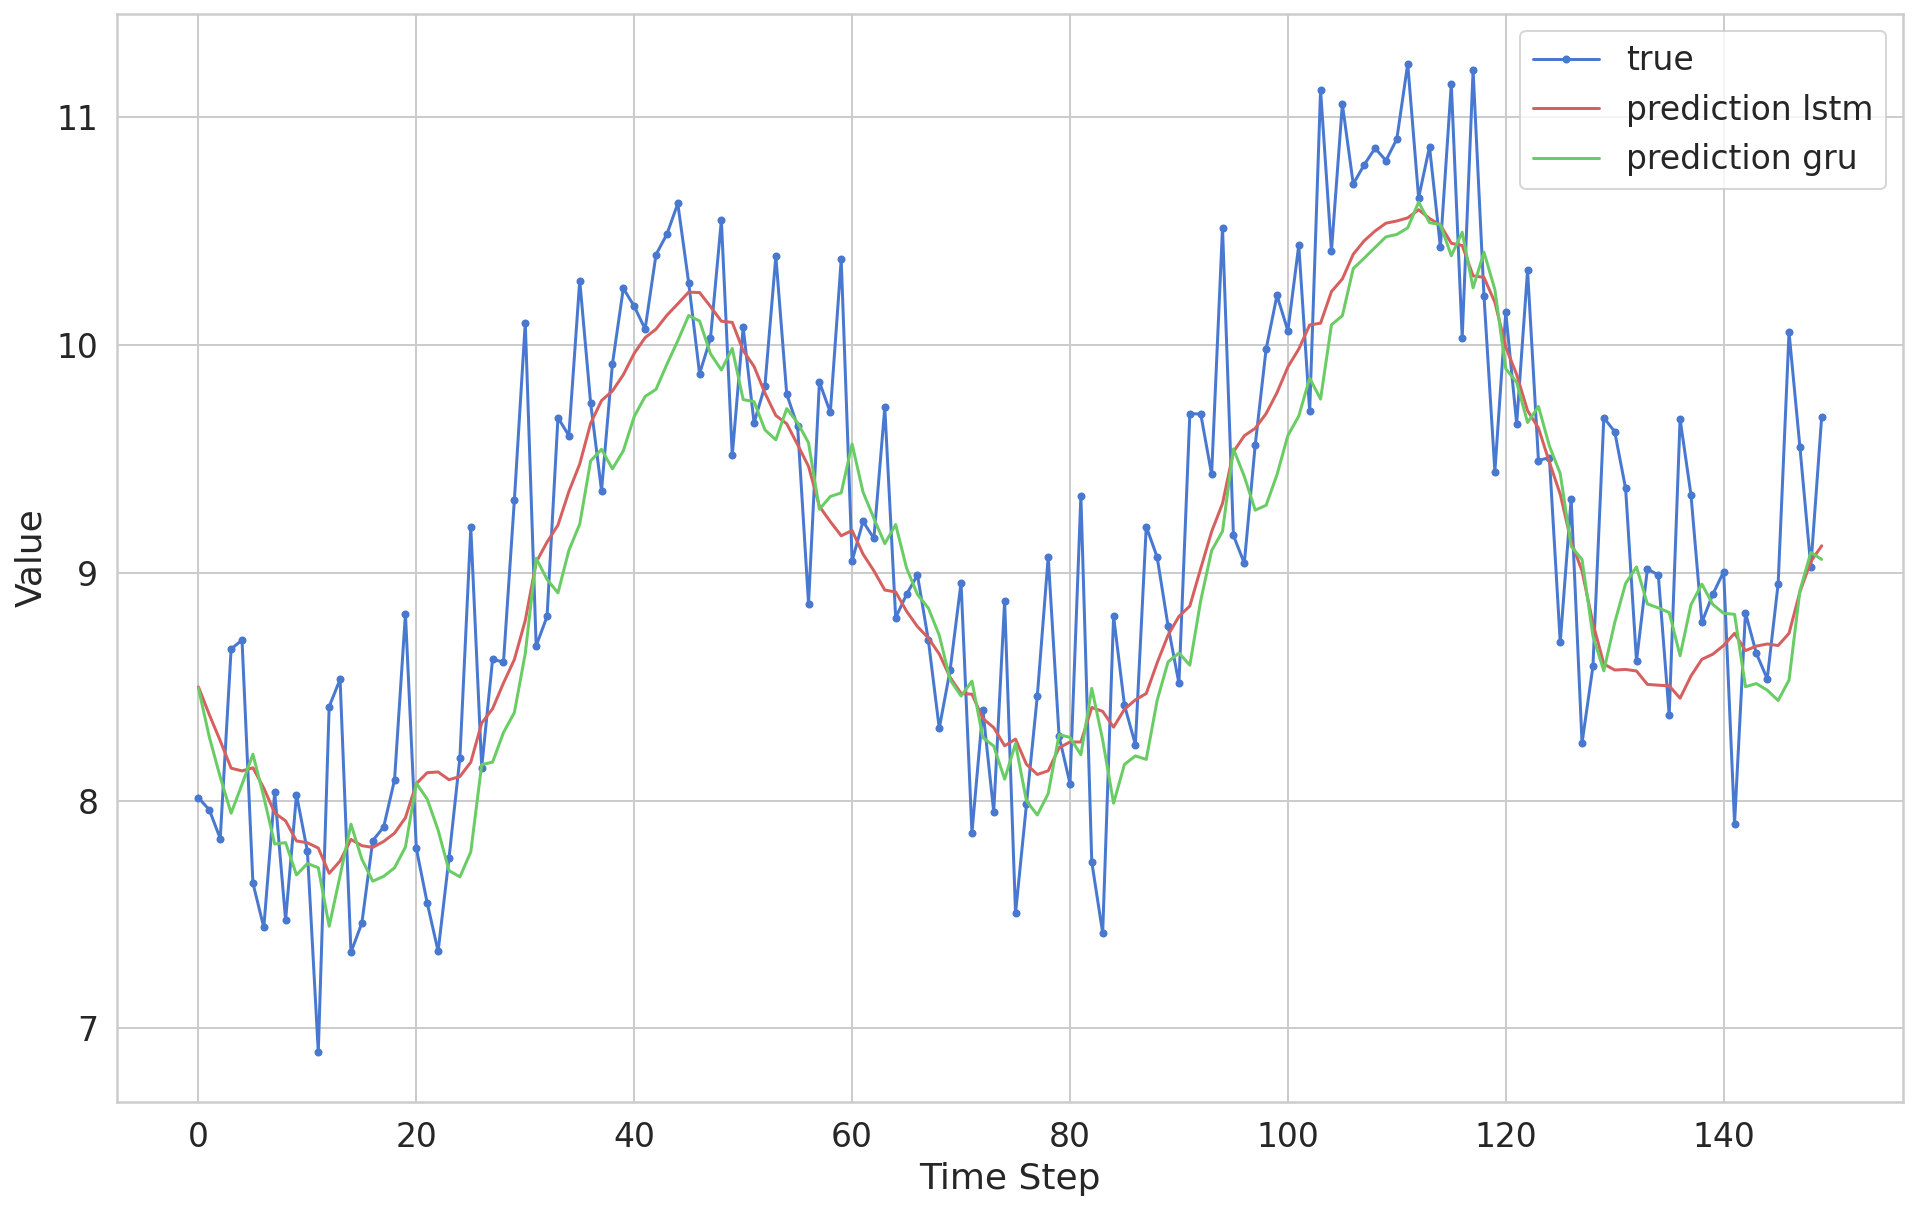

In [36]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction lstm")
plt.plot(y_pred_gru, 'g', label="prediction gru")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();


In [37]:
p= 60
n=1
3*(p*p +p*n+p)

11160